In [ ]:
import pandas as pd
data=pd.read_csv("FAOLEX_All.csv")
print(data.keys())

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [ ]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1



In [ ]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])


In [ ]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [ ]:
print(keywords[15])
print(stemmed_words[15])


['marine fisheries', ' traditional rights/customary rights', ' fishing authorization', ' allocation/quota', ' fishery management and conservation']
['marine fisheri', ' traditional rights/customary right', ' fishing author', ' allocation/quota', ' fishery management and conserv']


# Top2vec topic model

In [ ]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Jacob pc\anaconda3\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopyth

## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [ ]:
# Compute unqie countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [ ]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1

In [ ]:
# Compute country co-occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes()

country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num])
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1


In [ ]:
#Standardisering
"""
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)
for i in range(len(countries)):
    country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i])

"""

'\ndef get_swap_dict(d):\n    return {v: k for k, v in d.items()}\n\ncountries_swap = get_swap_dict(countries)\nfor i in range(len(countries)):\n    country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i])\n\n'

In [ ]:
def square_rooted(x):
   return round(np.sqrt(sum([a*a for a in x])),3)

def cosine_similarity(x,y):
 numerator = sum(a*b for a,b in zip(x,y))
 denominator = square_rooted(x)*square_rooted(y)
 return round(numerator/float(denominator),3)




In [ ]:
def co_occurence(country_new,similarity):
    country_co_ocurrence = np.zeros((len(set(country_new)),len(set(country_new))))
    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_ocurrence[i,j] = np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1]
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_ocurrence[i,j] = cosine_similarity(country_topic_matrix[i,:], country_topic_matrix[j,:])
    return country_co_ocurrence

country_co_ocurrence = co_occurence(country_new,"cosine")
np.shape(country_co_ocurrence)



(257, 257)

Country Network


In [ ]:
# swap dict

def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

print(countries_swap)


{0: 'Algeria', 1: 'Maldives', 2: 'Somalia', 3: 'Republic of Moldova', 4: 'Ghana', 5: 'Serbia', 6: 'Northern Mariana Islands (USA)', 7: 'Colombia', 8: 'Malaysia', 9: "Democratic People's Republic of Korea", 10: 'Norway', 11: 'Ethiopia', 12: 'Martinique (France)', 13: 'Niue (New Zealand)', 14: 'Türkiye', 15: 'Namibia', 16: 'Juan de Nova Island (France)', 17: 'India', 18: 'Micronesia (Federated States of)', 19: 'Cabo Verde', 20: 'North Macedonia', 21: 'French Guiana (France)', 22: 'American Samoa (USA)', 23: 'San Marino', 24: 'United States Virgin Islands', 25: 'Montenegro', 26: 'Sierra Leone', 27: 'Liechtenstein', 28: 'Iceland', 29: 'United States of America', 30: 'Cyprus', 31: 'Kuwait', 32: 'Syrian Arab Republic', 33: 'Eritrea', 34: 'Jan Mayen (Norway)', 35: 'Sao Tome and Principe', 36: 'Dominica', 37: 'Bahrain', 38: 'Malawi', 39: 'MERCOSUR', 40: 'South Georgia and the South Sandwich Islands (UK)', 41: 'Mauritania', 42: 'Nauru', 43: 'Kosovo (UNSCR 1244)', 44: 'Nepal', 45: 'Congo', 46: '

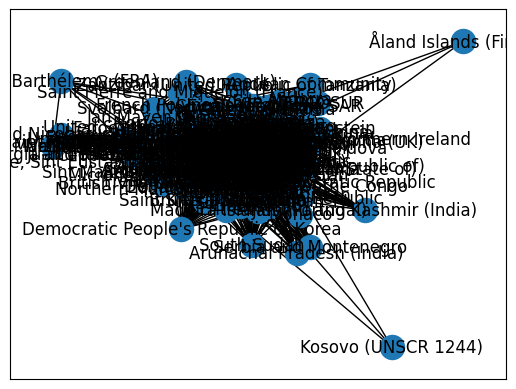

In [ ]:

from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

G = nx.Graph()

size = country_co_ocurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            #if country_co_ocurrence[i, j] != 0.0:
            if country_co_ocurrence[i, j] > 0.15:
                G.add_edge(i, j, weight=country_co_ocurrence[i, j])


nx.draw_networkx(G, labels=countries_swap,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)




In [ ]:
from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)

most_central_edge(G)

(212, 221)

In [ ]:

NUM_ITERATIONS = 1000
for i in range(NUM_ITERATIONS):
    #edge_betweenness = nx.edge_betweenness_centrality(G).items()
    #edge_to_delete = sorted(edge_betweenness, key=lambda pair: -pair[1])[0][0]
    edge_to_delete = most_central_edge(G)
    G.remove_edge(*edge_to_delete)
    print('Step %s\nEdge %s Deleted'%(i, edge_to_delete))


nx.draw_networkx(G, labels=countries_swap,with_labels=True,node_color='r')

KeyboardInterrupt: 

In [ ]:
#Fluidc method

In [ ]:
from networkx.algorithms.community import asyn_fluidc

k = 20


comp = girvan_newman(G)
#comp = asyn_fluidc(G,k=15, max_iter=100, seed=None)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))

#nx.draw_networkx(comp, with_labels=True)

communities = list(nx.community.girvan_newman(G))

print(communities)

In [ ]:

from collections import Counter
import random

__all__ = ['asyn_fluidc']

def asyn_fluidc(G, k, max_iter):
    """
    Fluid Communities: A Competitive and Highly Scalable Community Detection Algorithm.
    Args:
        - G: Graph to run the algorithm into.
            + type: networkx.Graph
        - k: Number of communities to search.
            + type: int
        - max_iter: Number of maximum iterations allowed.
            + type: int
    Return:
        - List of communities, where each community is a list of vertex ID.
          Each vertex ID can be either an int or str.
            + type: list(list(int or str))
    """
    # Initialization
    max_density = 1.0
    vertices = list(G)
    random.shuffle(vertices)
    communities = {n: i for i, n in enumerate(vertices[:k])}
    density = {}
    com_to_numvertices = {}
    for vertex in communities.keys():
        com_to_numvertices[communities[vertex]] = 1
        density[communities[vertex]] = max_density
    # Set up control variables and start iterating
    iter_count = 0
    cont = True
    while cont:
        cont = False
        iter_count += 1
        # Loop over all vertices in graph in a random order
        vertices = list(G)
        random.shuffle(vertices)
        for vertex in vertices:
            # Updating rule
            com_counter = Counter()
            # Take into account self vertex community
            try:
                com_counter.update({communities[vertex]: density[communities[vertex]]})
            except KeyError:
                pass
            # Gather neighbour vertex communities
            for v in G[vertex]:
                try:
                    com_counter.update({communities[v]: density[communities[v]]})
                except KeyError:
                    continue
            # Check which is the community with highest density
            new_com = -1
            if len(com_counter.keys()) > 0:
                max_freq = max(com_counter.values())
                best_communities = [com for com, freq in com_counter.items()
                                    if (max_freq - freq) < 0.0001]
                # If actual vertex com in best communities, it is preserved
                try:
                    if communities[vertex] in best_communities:
                        new_com = communities[vertex]
                except KeyError:
                    pass
                # If vertex community changes...
                if new_com == -1:
                    # Set flag of non-convergence
                    cont = True
                    # Randomly chose a new community from candidates
                    new_com = random.choice(best_communities)
                    # Update previous community status
                    try:
                        com_to_numvertices[communities[vertex]] -= 1
                        density[communities[vertex]] = max_density / \
                                                       com_to_numvertices[communities[vertex]]
                    except KeyError:
                        pass
                    # Update new community status
                    communities[vertex] = new_com
                    com_to_numvertices[communities[vertex]] += 1
                    density[communities[vertex]] = max_density / \
                                                   com_to_numvertices[communities[vertex]]
        # If maximum iterations reached --> output actual results
        if iter_count > max_iter:
            print('Exiting by max iterations!')
            break
    # Return results by grouping communities as list of vertices
    return list(_invert_dict(communities).values())

def _invert_dict(orig_dict):
    """
    Inverting Python dictionary keys and values: Many to one --> One to many
    Args:
        - orig_dict: Dictionary desired to invert.
            + type: dict
    Return:
        - Inverted dictionary
            + type: dict
    """
    return_dict = {}
    for v, k in orig_dict.items():
        try:
            return_dict[k].append(v)
        except KeyError:
            return_dict[k] = [v]
    return return_dict

In [ ]:
f_communities = asyn_fluidc(G,k=100,max_iter=100000)


community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(f_communities):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap)
plt.show()


In [ ]:
i=1

for community in f_communities:
    print("c",i)
    for country in community:
        print(countries_swap[country])

    i=i+1


In [ ]:
#louvain method

In [29]:

from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=2)
unique_coms = np.unique(list(comms))


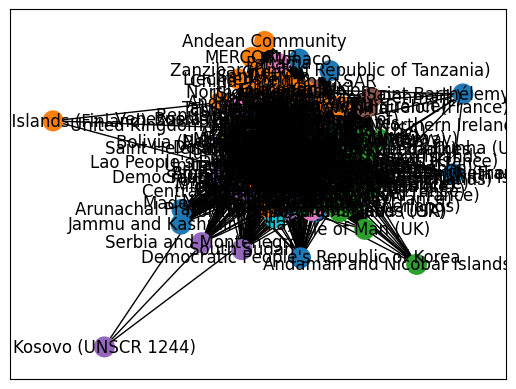

In [30]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap)
plt.show()

In [31]:
i=1

for community in comms:
    print("c",i)
    for country in community:
        print(countries_swap[country])

    i=i+1

c 1
Gambia
Democratic People's Republic of Korea
Romania
c 2
Dominican Republic
c 3
Thailand
Myanmar
c 4
Martinique (France)
Saint Martin (France)
Saint Barthélemy (FRA)
French Guiana (France)
New Caledonia (France)
c 5
Azerbaijan
Türkiye
c 6
India
Jammu and Kashmir (India)
Arunachal Pradesh (India)
Iraq
c 7
Monaco
Bulgaria
North Macedonia
Serbia
Croatia
Bosnia and Herzegovina
Montenegro
c 8
Dominica
Bahamas
Northern Mariana Islands (USA)
Tonga
Samoa
Zanzibar (United Republic of Tanzania)
Norfolk Island (Australia)
Montserrat (UK)
Guam (USA)
Antigua and Barbuda
Micronesia (Federated States of)
Barbados
American Samoa (USA)
c 9
Germany
Liechtenstein
Nigeria
Switzerland
Canada
c 10
Israel
Guernsey (UK)
French Polynesia (France)
Jersey  (UK)
c 11
Saint Helena, Ascension and Tristan da Cunha (UK)
c 12
Mauritania
c 13
Liberia
Central African Republic
Congo
Suriname
Gabon
Côte d'Ivoire
Democratic Republic of the Congo
Cameroon
c 14
Zambia
c 15
Andean Community
Slovenia
Austria
Portugal
Greec